# Computing the nonadiabatic couplings in Kohn-Sham and excited states bases

In this tutorial, we will start computing the nonadiabatic couplings (NACs) from the molecular orbital overlap files obtained in [step2](../../7_step2_cp2k/1_DFT). The NACs will be computed in Kohn-Sham states and also in both single-partcile (SP) and many-body (MB) excited state bases. Finally we will plot the excited states energies vs time and NAC map.

## Table of contents
<a name="toc"></a>
1. [Importing needed libraries](#import)
2. [Overview of required files](#required_files)
3. [Computing the NACs](#comp_nacs)     
    3.1. [Kohn-Sham basis](#KS)\
    3.2. [Excited state basis](#excited_states)
4. [Plotting the results](#plotting)\
    4.1. [NAC distribution](#nac_dist)\
    4.2. [Energy vs time](#ene_time)\
    4.3. [NAC map](#nac_map)

### A. Learning objectives

* To be able to compute the NACs in Kohn-Sham and excited state bases
* To be able to plot the NACs distribution 
* To be able to plot the computed excited states energies vs time
* To be able to plot the NAC map

### B. Use cases

* [Computing the NACs](#comp_nacs)
* [Plotting the results](#plotting)


### C. Functions

- `libra_py`
  - `data_stat`
    -  `cmat_distrib`
  - `workflows`
    - `nbra`
      - [`step3`](#comp_nacs)
        - [`run_step3_ks_nacs_libint`](#KS)
        - [`run_step3_sd_nacs_libint`](#excited_states)
  - `units`
    - `au2ev`


## 1. Importing needed libraries <a name="import"></a>
[Back to TOC](#toc)

Since the data are stored in sparse format using `scipy.sparse` library, we need to load this library so that we can read and check the orthonormality of the data.
Import `numpy`, `scipy.sparse`, `data_stat`, `data_io`, `units`, and `step3` modules. Also, `glob` will be needed to find specific types of files.

In [1]:
import os
import sys
import time
import glob
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from liblibra_core import *
from libra_py.workflows.nbra import step3
from libra_py import units, data_stat, data_io

/projects/academic/alexeyak/mohammad/software/miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/alexeyak/mohammad/software/miniconda3/envs/libra/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: to-Python converter for boost::python::detail::container_element<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, unsigned long, boost::python::detail::final_vector_derived_policies<std::vector<std::vector<int, std::allocator<int> >, std::allocator<std::vector<int, std::allocator<int> > > >, false> > already registered; second conversion method ignored.
  return f(*args, **kwds)
/projects/academic/alexeyak/mohammad/software/miniconda3/envs/libra/lib/python3.6/import

## 2. Overview of required files <a name="required_files"></a>
[Back to TOC](#toc)

* `../../7_step2_cp2k/1_DFT/2_hpc/res`

The MO overlap files are needed and stored in this folder.

* `../../7_step2_cp2k/1_DFT/2_hpc/all_logfiles`

All of the logfiles obtained from the electronic structure calculations of CP2K. These files will be needed to find the Kohn-Sham HOMO index and also extract the the TD-DFT data for each step.

## 3. Computing the NACs <a name="comp_nacs"></a>
[Back to TOC](#toc)

### 3.1. Kohn-Sham basis <a name="KS"></a>

The `libra_py.workflow.nbra.step3.run_step3_ks_nacs_libint(params)` computes the NACs between pairs of Kohn-Sham states using the molecular orbital 
overlaps. The paramters for this function are as follows:

`params['lowest_orbital']`: The lowest orbital considered in the computation of the MO overlaps. This value is exactly the same
as in the `run_template.py` file in step2.

`params['highest_orbital']`: The highest orbital considered in the computation of the MO overlaps. This value is exactly the same
as in the `run_template.py` file in step2.

`params['num_occ_states']`: The number of occupied orbitals to be considered from HOMO to lower occupied states. This value is defined by user.

`params['num_unocc_states']`: The number of unoccupied orbitals to be considered from LUMO to higher unoccupied states. This value is defined by user.

The two values above are used to create an active space which then will be used to select the elements from the MO overlap and energy matrices.

`params['use_multiprocessing']`: A boolean flag to use the multiprocessing library of Python or not.

`params['nprocs']`: The number of processors to be used for the calculations. Libra will use this only if the `params['use_multiprocessing']` 
is set to `True`.

`params['time_step']`: The time-step used in the calculations in `fs`.

`params['es_software']`: The name of the software package used to compute the electronic structure calculations. This will be used to generate the HOMO 
index of that system so it can build the active space.

`params['path_to_npz_files']`: The full path to the MO overlap files.

`params['logfile_directory']`: The full path to the folder where all the log files are stored.

`params['path_to_save_ks_Hvibs']`: The full path to the folder in which the NACs between the Konh-Sham states are stored.

`params['start_time']`: The start time-step.

`params['finish_time']`: The finish time-step.

`params['apply_phase_correction']`: A boolean flag for applying phase-correction algorithm.

`params['apply_orthonormalization']`: A boolean flag for applying the orthonormalization algorithm.

`params['do_state_reordering']`: If this value is set to `1` or `2`, the state-reordering will be applied to overlap matrices.

`params['state_reordering_alpha']`: The state-reordering alpha value if the `params['do_state_reordering'] = 2`.

After setting all the above paramters, the calculations are run using `step3.run_step3_ks_nacs_libint(params)`.

In [2]:
params_ks = {
          'lowest_orbital': 24-10, 'highest_orbital': 24+11, 'num_occ_states': 10, 'num_unocc_states': 10,
          'use_multiprocessing': True, 'nprocs': 4, 'time_step': 1.0, 'es_software': 'cp2k',
          'path_to_npz_files': os.getcwd()+'/../../7_step2_cp2k/1_DFT/2_hpc/res',
          'logfile_directory': os.getcwd()+'/../../7_step2_cp2k/1_DFT/2_hpc/all_logfiles',
          'path_to_save_ks_Hvibs': os.getcwd()+'/res-ks',
          'start_time': 1, 'finish_time': 49,
          'apply_phase_correction': True, 'apply_orthonormalization': True,
          'do_state_reordering': 2, 'state_reordering_alpha':0
         }

#### For KS states - Applying correction to KS overlaps and computing the NACs in KS space
step3.run_step3_ks_nacs_libint(params_ks)

Computing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in stepComputing orthonormalization of St matrices in step    47110



Done with step Done with step10  1. Elapsed time: . Elapsed time:  0.207325458526611330.19896745681762695
Computing orthonormalization of St matrices in step Done with step
2 
4Computing orthonormalization of St matrices in step  . Elapsed time:11 Done with step
 0.263359546661376957 
. Elapsed time:Computing orthonormalization of St matrices in step Done with step0.30754971504211426  2
 . Elapsed time:5Computing orthonormalization of St matrices in step 0.09647035598754883

 Computing orthonormalization of St matrices in stepDone with step 83
 
11 . Elapsed time: 0.11945438385009766
Done with stepDone with stepComputing orthonormalization of St matrices in step  3  5. Elapsed time:Done with step12 0.09734749794006348
 Computing orthonormalization of St matrices in step 
 

### 3.2. Excited state basis <a name="excited_states"></a>

The NACs can also be computed between excited states. These include the single-particle and many-body bases which the latter is obtained from the
TD-DFT calculations. First, we need to compute the overlap between excited state Slater-determinants (SDs) then they will be used to compute the NACs
between them. For many-body states, the configuration interaction coefficietns will also be used. We will consider both single-particle 
and many-body for DFT calculations but only single-particle for xTB.

To run the calculations `step3.run_step3_sd_nacs_libint(params)` function will be used. Some parameters are common with the ones used to run `step3.run_step3_ks_nacs_libint(params)`.

There are different ways of defining the excited states SDs (the single-particle excited state basis). The first is through 
defining the `num_occ_states` and `num_unocc_states` in which Libra
will start making the SDs from all of the occupied states (starting from `HOMO-num_occ_states+1`) to all of the unoccupied states (ends
to `LUMO+num_unocc_states-1`). Also, if the unrestricted spin calculation flag is set to `True`, the SDs will be made for both alpha and beta spin channels. 

For example, if you want to build the electron-only excitation basis, you need to set `params['num_occ_states'] = 1` and set `params['num_unocc_states']`
to a value less than the number of unoccupied orbitals that was considered in the computation of overlaps. This will generate all the electron-only
excitation from HOMO to unoccupied states.

If the TD-DFT calculations has been done, then Libra will go over all log files and 
generate all the SDs used for all the steps and therefore the definition of these SDs is automatic and Libra will replace the `num_occ_states` and
`num_unocc_states` itself based on the SDs that were generated from the TD-DFT log files. 



Other parameters needed to run the `step3.run_step3_sd_nacs_libint(params)` function are as follows:

`params['isUKS']`: A boolean flag for unrestricted spin calculations.

`params['is_many_body']`: If set to `True`, the NACs will be computed between pairs of many-body (TD-DFT) states. Also, the NACs between single-particle 
SDs obtained from the TD-DFT results will be computed as well. Otherwise, only single-particle NACs will be computed only for the SDs obtained from
`num_occ_states` and `num_unocc_states`. This will be used for xTB calculations in which no TD-DFT is performed.

`params['number_of_states']`: The number of TD-DFT states to consider. This value should not exceed the number of requested TD-DFT states in the CP2K
calculations.

`params['tolerance']`: A lower bound for selection of the excitation with configuration interaction coefficients higher than this value.

`params['verbosity']`: An integer value showing the printing level. The default is set to 0. Higher values will print more data on terminal.

`params['sorting_type']`: After defining the SDs, Libra will sort them either based on `'energy'` or `'identity'`.




In [3]:
#### For excited states - Computing the excited states SDs and their overlaps and NACs
params_mb_sd = {
          'lowest_orbital': 24-10, 'highest_orbital': 24+11, 'num_occ_states': 10, 'num_unocc_states': 10,
          'isUKS': 0, 'number_of_states': 5, 'tolerance': 0.01, 'verbosity': 0,
          'use_multiprocessing': True, 'nprocs': 4,
          'is_many_body': True, 'time_step': 1.0, 'es_software': 'cp2k',
          'path_to_npz_files': os.getcwd()+'/../../7_step2_cp2k/1_DFT/2_hpc/res',
          'logfile_directory': os.getcwd()+'/../../7_step2_cp2k/1_DFT/2_hpc/all_logfiles',
          'path_to_save_sd_Hvibs': os.getcwd()+'/res-mb-sd',
          'outdir': os.getcwd()+'/res-mb-sd',
          'start_time': 1, 'finish_time': 49, 'sorting_type': 'identity',
          'apply_phase_correction': True, 'apply_orthonormalization': True,
          'do_state_reordering': 2, 'state_reordering_alpha':0
         }


step3.run_step3_sd_nacs_libint(params_mb_sd)

sd_unique_basis is: [[[24, 25], 'alp'], [[23, 25], 'alp'], [[22, 25], 'alp'], [[24, 27], 'alp'], [[24, 28], 'alp'], [[24, 26], 'alp'], [[24, 29], 'alp'], [[21, 25], 'alp'], [[23, 26], 'alp'], [[23, 27], 'alp'], [[21, 28], 'alp'], [[22, 26], 'alp'], [[23, 29], 'alp'], [[22, 27], 'alp'], [[21, 26], 'alp'], [[22, 28], 'alp']]
sd_states_reindexed is: [[1, -1, 2, -2, 3, -3, 4, -4], [1, -1, 2, -2, 3, -3, 5, -4], [1, -1, 2, -2, 5, -3, 4, -4], [1, -1, 5, -2, 3, -3, 4, -4], [1, -1, 2, -2, 3, -3, 7, -4], [1, -1, 2, -2, 3, -3, 8, -4], [1, -1, 2, -2, 3, -3, 6, -4], [1, -1, 2, -2, 3, -3, 9, -4], [5, -1, 2, -2, 3, -3, 4, -4], [1, -1, 2, -2, 6, -3, 4, -4], [1, -1, 2, -2, 7, -3, 4, -4], [8, -1, 2, -2, 3, -3, 4, -4], [1, -1, 6, -2, 3, -3, 4, -4], [1, -1, 2, -2, 9, -3, 4, -4], [1, -1, 7, -2, 3, -3, 4, -4], [6, -1, 2, -2, 3, -3, 4, -4], [1, -1, 8, -2, 3, -3, 4, -4]]
ks_homo_index 24
ks_orbital_indicies range(21, 30)
Sorting and computing the SDs energies...
Done with sorting and computing the SDs energie

Computing the SD overlaps for stepDone with computing the SD overlap of step 35. Elapsed time 0.022765636444091797 45

Applying orthonormalization for SDs for step 41
Done with computing the SD overlap of step 41. Elapsed time 0.015573263168334961
Applying orthonormalization for SDs for step 44
Applying orthonormalization for SDs for step 45
Done with computing the SD overlap of step 44. Elapsed time 0.014835357666015625
Done with computing the SD overlap of step 45. Elapsed time 0.015194177627563477
Computing the SD overlaps for step 46
Applying orthonormalization for SDs for step 46
Done with computing the SD overlap of step 46. Elapsed time 0.01538395881652832
Done with computing the SD overlaps. Elapsed time: 0.6427860260009766
Applying state-reordering to SDs overlaps...

Done with state-reordering of SDs. Elapsed time: 0.13340282440185547
Applying state-reordering to St_ci...

Done with state-reordering to St_cis. Elapsed time: 1.0706958770751953


## 4. Plotting the results <a name='plotting'></a>
[Back to TOC](#toc)

### 4.1. NAC distribution <a name='nac_dist'></a>

One of the intuitive ways to visualize the NACs is to plot the distribution of the NACs. Here we plot them for SP and MB excited states.

<IPython.core.display.Javascript object>


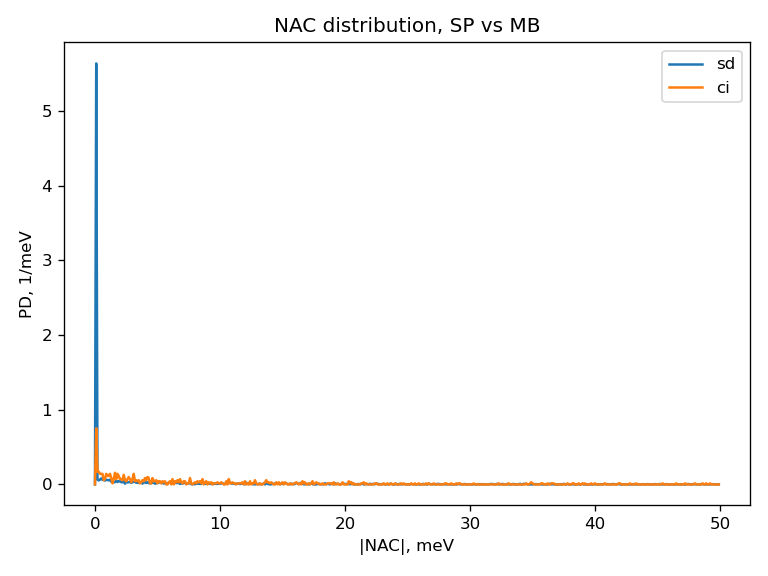

In [5]:
%matplotlib notebook

for basis in ['sd','ci']:
    nac = []
    nac_files = glob.glob(F'res-mb-sd/Hvib_{basis}*im*')
    for nac_file in nac_files:
        hvib = sp.load_npz(nac_file)
        hvib_dense = hvib.todense().real
        for i in range(hvib.shape[0]):
            for j in range(hvib.shape[0]):
                if j != i:
                    nac_ij = np.abs(hvib_dense[i,j])* 1000.0 * units.au2ev
                    x_mb = MATRIX(1,1)
                    x_mb.set(0, 0, nac_ij )
                    nac.append( x_mb )
    bin_supp, dens, cum = data_stat.cmat_distrib( nac, 0, 0, 0, 0, 50, 0.1)
    plt.plot( bin_supp, dens, label=basis)
plt.xlabel('|NAC|, meV')
plt.ylabel('PD, 1/meV')
plt.title('NAC distribution, SP vs MB')
plt.legend()
plt.tight_layout()
# plt.savefig('nac_dist_1.jpg', dpi=600)

### 4.2. Energy vs time <a name='ene_time'></a>
Here, we plot the excited states energy vs time. Since the excited states were sorted by their `'identity'` it is easy to visualize the states energies crossings.

Sorted energy files are: ['res-mb-sd/Hvib_sd_1_re.npz', 'res-mb-sd/Hvib_sd_2_re.npz', 'res-mb-sd/Hvib_sd_3_re.npz', 'res-mb-sd/Hvib_sd_4_re.npz', 'res-mb-sd/Hvib_sd_5_re.npz', 'res-mb-sd/Hvib_sd_6_re.npz', 'res-mb-sd/Hvib_sd_7_re.npz', 'res-mb-sd/Hvib_sd_8_re.npz', 'res-mb-sd/Hvib_sd_9_re.npz', 'res-mb-sd/Hvib_sd_10_re.npz', 'res-mb-sd/Hvib_sd_11_re.npz', 'res-mb-sd/Hvib_sd_12_re.npz', 'res-mb-sd/Hvib_sd_13_re.npz', 'res-mb-sd/Hvib_sd_14_re.npz', 'res-mb-sd/Hvib_sd_15_re.npz', 'res-mb-sd/Hvib_sd_16_re.npz', 'res-mb-sd/Hvib_sd_17_re.npz', 'res-mb-sd/Hvib_sd_18_re.npz', 'res-mb-sd/Hvib_sd_19_re.npz', 'res-mb-sd/Hvib_sd_20_re.npz', 'res-mb-sd/Hvib_sd_21_re.npz', 'res-mb-sd/Hvib_sd_22_re.npz', 'res-mb-sd/Hvib_sd_23_re.npz', 'res-mb-sd/Hvib_sd_24_re.npz', 'res-mb-sd/Hvib_sd_25_re.npz', 'res-mb-sd/Hvib_sd_26_re.npz', 'res-mb-sd/Hvib_sd_27_re.npz', 'res-mb-sd/Hvib_sd_28_re.npz', 'res-mb-sd/Hvib_sd_29_re.npz', 'res-mb-sd/Hvib_sd_30_re.npz', 'res-mb-sd/Hvib_sd_31_re.npz', 'res-mb-sd/Hvib_sd_32_

<IPython.core.display.Javascript object>


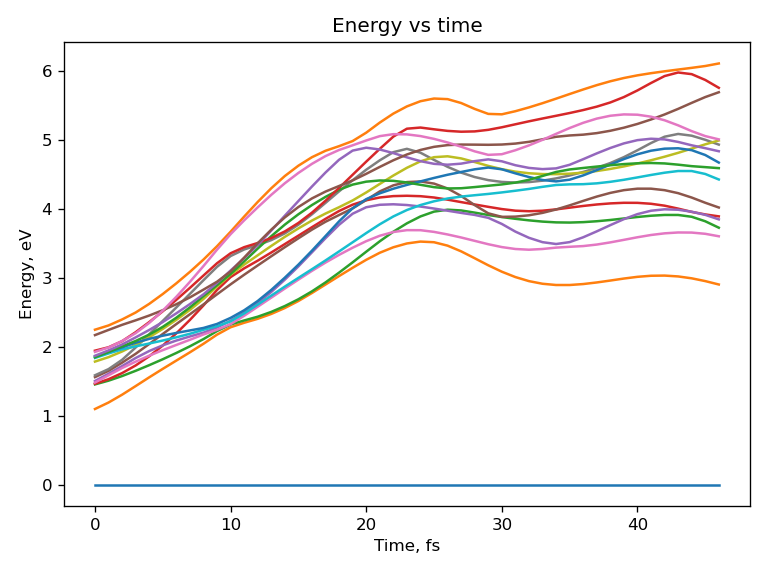

In [6]:
%matplotlib notebook
energy_files = glob.glob('res-mb-sd/Hvib_sd*re*')
energy_files = data_io.sort_hvib_file_names(energy_files)
print('Sorted energy files are:', energy_files)
dt = 1.0 # fs
energies = []
for file in energy_files:
    energies.append(np.diag(sp.load_npz(file).todense().real))
energies = np.array(energies)*units.au2ev
md_time = np.arange(0,energies.shape[0]*dt,dt)
print(energies.shape)
for i in range(energies.shape[1]):
    plt.plot(md_time, energies[:,i]-energies[:,0])
plt.title('Energy vs time')
plt.ylabel('Energy, eV')
plt.xlabel('Time, fs')
plt.tight_layout()

### 4.3. NAC map <a name='nac_map'></a>
Another way of visualizing the NAC values is to plot the average NAC matrix using `plt.imshow`.

<IPython.core.display.Javascript object>


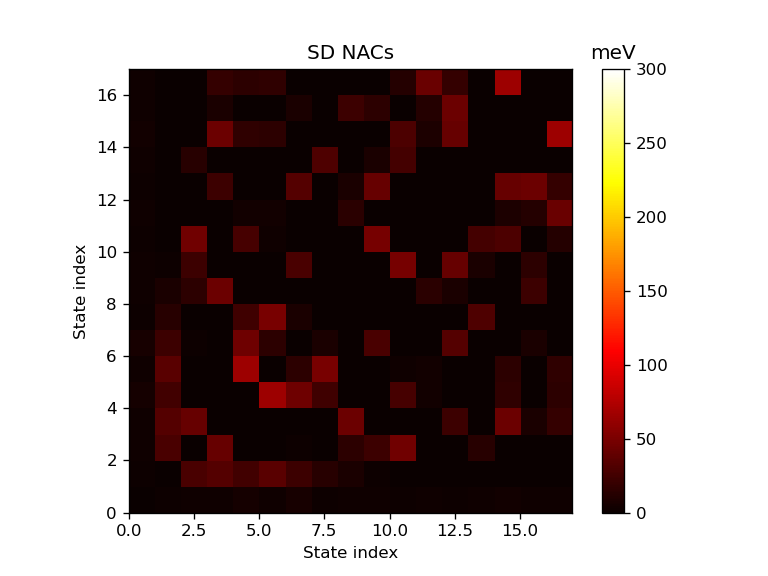

Text(0.5, 1.0, 'SD NACs')

In [7]:
%matplotlib notebook
plt.figure()
nac_files = glob.glob('res-mb-sd/Hvib_sd*im*')
for c, nac_file in enumerate(nac_files):
    nac_mat = sp.load_npz(nac_file).todense().real
    if c==0:
        nac_ave = np.zeros(nac_mat.shape)
    nac_ave += np.abs(nac_mat)
nac_ave *= 1000*units.au2ev/c
nstates = nac_ave.shape[0]
plt.imshow(np.flipud(nac_ave), cmap='hot', extent=(0,nstates,0,nstates), vmin=0, vmax=300)
plt.xlabel('State index')
plt.ylabel('State index')
plt.colorbar().ax.set_title('meV')
plt.title('SD NACs')

<IPython.core.display.Javascript object>


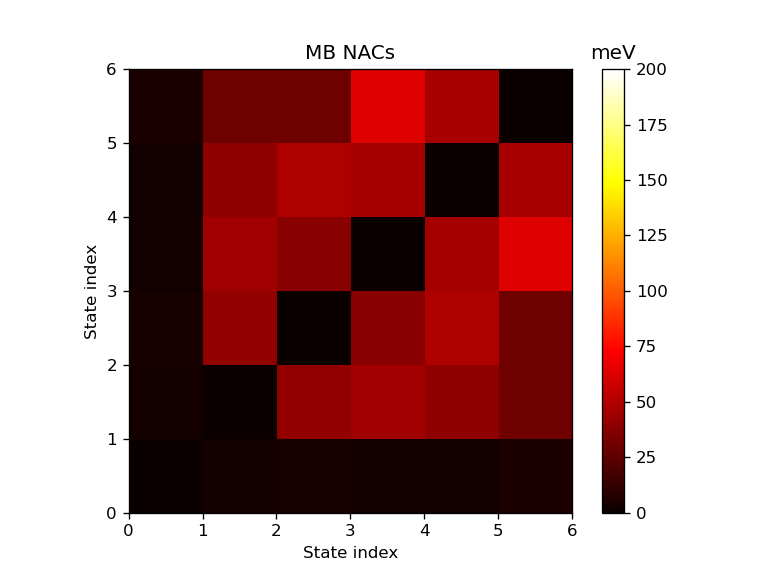

Text(0.5, 1.0, 'MB NACs')

In [8]:
%matplotlib notebook
nac_files = glob.glob('res-mb-sd/Hvib_ci*im*')
for c, nac_file in enumerate(nac_files):
    nac_mat = sp.load_npz(nac_file).todense().real
    if c==0:
        nac_ave = np.zeros(nac_mat.shape)
    nac_ave += np.abs(nac_mat)
nac_ave *= 1000*units.au2ev/c
nstates = nac_ave.shape[0]
plt.imshow(np.flipud(nac_ave), cmap='hot', extent=(0,nstates,0,nstates), vmin=0, vmax=200)
plt.xlabel('State index')
plt.ylabel('State index')
plt.colorbar().ax.set_title('meV')
plt.title('MB NACs')